# Particle independent Metropolis-Hastings (PIMH)

Notebook about testing the PIMH algorithm.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import os
import sys

# Add parent directory to sys.path
print(os.getcwd())
parent_dir = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.append(parent_dir)

d:\School\Fakulteta\2. stopnja\2. letnik\Master\notebooks


In [2]:
from src.models.lgm import LGModelParams, LGModel
from src.models.mssv import MSSVModelParams, MSSVModel
from src.filters.kalman.kalman_filter import KalmanFilter
from src.filters.pmcmc.pimh import ParticleIndependentMetropolisHastings
from src.filters.smc.bootstrap_pf import BootstrapParticleFilter
from src.filters.smc.resampling import systematic_resampling
from src.data_generation.simulate_data import simulate_data

## PIMH on LG model

First, we test the PIMH on the linear Gaussian model, where we can compare the results to the Kalman filter.

In [3]:
# Set random seed for reproducibility
rng = np.random.default_rng(123)

# True parameters
theta = LGModelParams(
    a=0.7,
    b=1.0,
    sigma_x=0.6,
    sigma_y=0.8,
)

# Initialize model
model = LGModel(rng=rng)

In [4]:
T = 100

x_true, y = simulate_data(model, theta, T, rng)

In [5]:
x_true = [x.x_t for x in x_true]  # Extract state values from State objects
x_true = np.array(x_true)
print(x_true.shape)
print(y.shape)

(100, 1)
(100, 1)


In [6]:
# Kalman Filter
kf = KalmanFilter()
mu_smooth, var_smooth = kf.smoother(y, theta)

In [7]:
N = 400

bpf = BootstrapParticleFilter(model, N, resampler=systematic_resampling)

history = bpf.run(y, theta)
trajectories = bpf.smoothing_trajectories(history)

In [8]:
trajectories_x = np.array([state.x_t for state in trajectories])    # shape (T, n_traj)

In [9]:
x_mean = trajectories_x.mean(axis=1)  # mean across trajectories for each time step

In [10]:
logliks = []
for _ in range(200):
    history = bpf.run(y, theta)
    logliks.append(history[-1][3])

np.var(logliks)
print(f"Variance of log-likelihood estimates: {np.var(logliks):.4f}")

Variance of log-likelihood estimates: 0.1751


In [11]:
# Now we run the PIMH algorithm
pimh = ParticleIndependentMetropolisHastings(bpf)
samples, logmarliks = pimh.run(y, theta, n_iter=1000, burnin=0, verbose=True)

Iteration 100/1000, Acceptance Rate: 0.687
Iteration 200/1000, Acceptance Rate: 0.764
Iteration 300/1000, Acceptance Rate: 0.776
Iteration 400/1000, Acceptance Rate: 0.757
Iteration 500/1000, Acceptance Rate: 0.764
Iteration 600/1000, Acceptance Rate: 0.773
Iteration 700/1000, Acceptance Rate: 0.775
Iteration 800/1000, Acceptance Rate: 0.780
Iteration 900/1000, Acceptance Rate: 0.778
Iteration 1000/1000, Acceptance Rate: 0.787


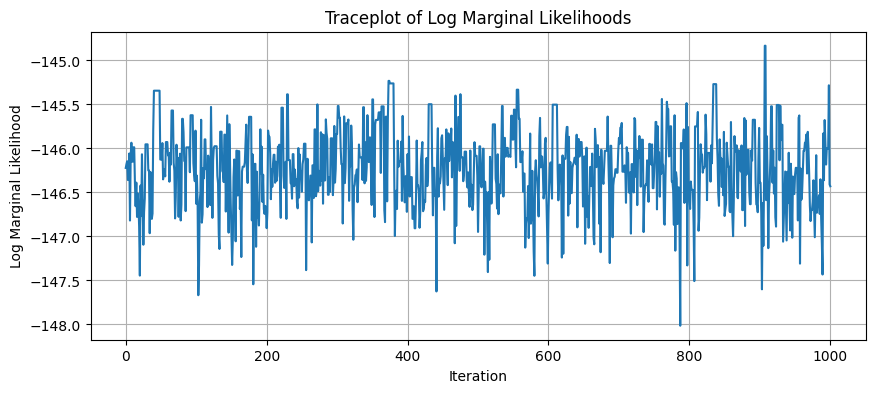

In [12]:
# Traceplot of log marginal likelihoods
plt.figure(figsize=(10, 4))
plt.plot(logmarliks)
plt.title('Traceplot of Log Marginal Likelihoods')
plt.xlabel('Iteration')
plt.ylabel('Log Marginal Likelihood')
plt.grid()
plt.show()

In [13]:
trajectories_x = np.array([state.x_t for state in samples])    # shape (T, n_traj)

x_mean_pimh = trajectories_x.mean(axis=1)  # mean across trajectories for each time step

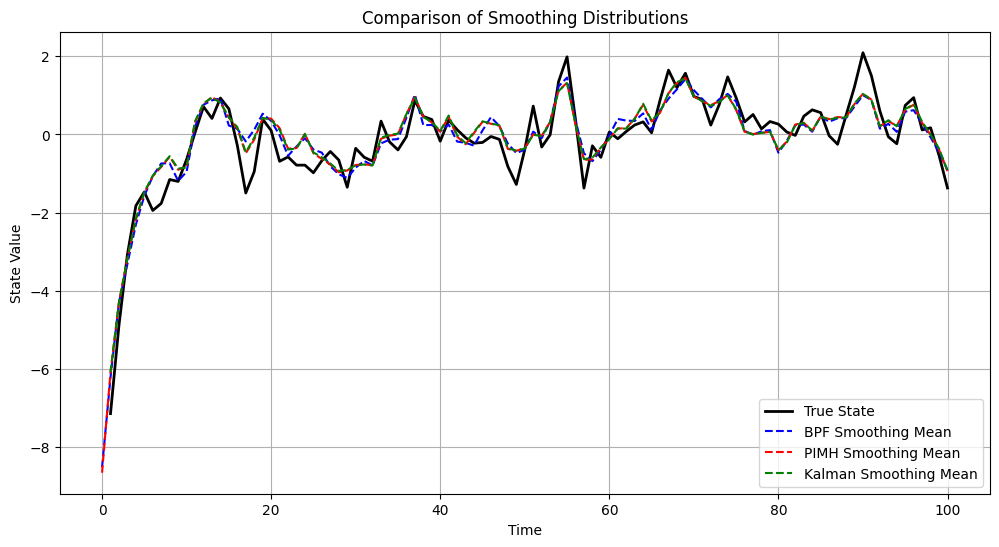

In [14]:
# Compare smoothing distribution from trajectories with smoothing distribution from PIMH samples relative to the true states
plt.figure(figsize=(12, 6))
plt.plot(np.arange(1, len(x_true) + 1), x_true, label='True State', color='black', linewidth=2)                 # Data starts at t=1
plt.plot(np.arange(0, len(x_mean)), x_mean, label='BPF Smoothing Mean', color='blue', linestyle='--')           # At t=0 we have the prior 
plt.plot(np.arange(0, len(x_mean_pimh)), x_mean_pimh, label='PIMH Smoothing Mean', color='red', linestyle='--') # Same here, t=0 is the prior
plt.plot(np.arange(1, len(mu_smooth) + 1), mu_smooth, label='Kalman Smoothing Mean', color='green', linestyle='--') # Kalman smoother mean starts at t=1
plt.title('Comparison of Smoothing Distributions')
plt.xlabel('Time')
plt.ylabel('State Value')
plt.legend()
plt.grid()
plt.show()

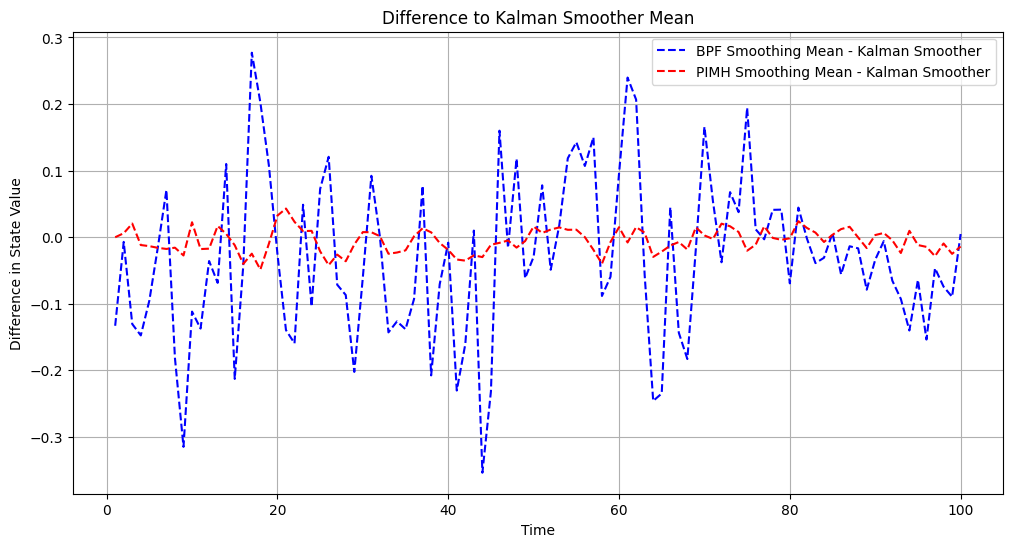

In [15]:
# Plot difference to analytical solution from Kalman smoother
plt.figure(figsize=(12, 6))
plt.plot(np.arange(1, len(mu_smooth) + 1), x_mean[1:] - mu_smooth, label='BPF Smoothing Mean - Kalman Smoother', color='blue', linestyle='--')           # At t=0 we have the prior 
plt.plot(np.arange(1, len(mu_smooth) + 1), x_mean_pimh[1:] - mu_smooth, label='PIMH Smoothing Mean - Kalman Smoother', color='red', linestyle='--') # Same here, t=0 is the prior
plt.title('Difference to Kalman Smoother Mean')
plt.xlabel('Time')
plt.ylabel('Difference in State Value')
plt.legend()
plt.grid()
plt.show()

## PIMH on MSSV model

Now we test the PIMH on the Markov switching stochastic volatility model. Here we don't have an analytical solution, so we will just compare of PIMH and the bootstrap particle filter to underlying true state.

In [3]:
# Set random seed for reproducibility
rng = np.random.default_rng(123)

# True parameters
theta = MSSVModelParams(
    mu=[-1.0, 1.6],
    phi=[0.95, 0.95],
    sigma_eta=[0.1, 0.2],
    P=[[0.95, 0.05],
        [0.05, 0.95]]
)

# Initialize model
model = MSSVModel(rng=rng)

In [4]:
T = 300

x_true, y = simulate_data(model, theta, T, rng)

In [5]:
h_true = np.array([x.h_t for x in x_true])  # Extract state values from State objects
s_true = np.array([x.s_t for x in x_true])  # Extract regime values from State objects
print(h_true.shape)
print(s_true.shape)
print(y.shape)

(300, 1)
(300, 1, 2)
(300, 1)


In [6]:
N = 400

bpf = BootstrapParticleFilter(model, N, resampler=systematic_resampling)

history = bpf.run(y, theta)
trajectories = bpf.smoothing_trajectories(history)

In [7]:
trajectories_h = np.array([state.h_t for state in trajectories])    # shape (T, n_traj)
trajectories_s = np.array([state.s_t for state in trajectories])    # shape (T, n_traj)

print(trajectories_h.shape)
print(trajectories_s.shape)

(301, 400)
(301, 400, 2)


In [8]:
# Extract probability of being in regime 1 from the trajectories by taking the second element of third component
trajectories_s_prob = trajectories_s[:, :, 1]  # shape (T, n_traj)

In [9]:
# Taking mean across trajectories for each time step
h_mean = trajectories_h.mean(axis=1)  # shape (T,)
s_prob_mean = trajectories_s_prob.mean(axis=1)  # shape (T,)

In [10]:
logliks = []
for _ in range(200):
    history = bpf.run(y, theta)
    logliks.append(history[-1][3])

np.var(logliks)
print(f"Variance of log-likelihood estimates: {np.var(logliks):.4f}")

Variance of log-likelihood estimates: 0.2018


In [11]:
# Now we run the PIMH algorithm
pimh = ParticleIndependentMetropolisHastings(bpf)
samples, logmarliks = pimh.run(y, theta, n_iter=1000, burnin=0, verbose=True)

Iteration 100/1000, Acceptance Rate: 0.798
Iteration 200/1000, Acceptance Rate: 0.799
Iteration 300/1000, Acceptance Rate: 0.786
Iteration 400/1000, Acceptance Rate: 0.759
Iteration 500/1000, Acceptance Rate: 0.741
Iteration 600/1000, Acceptance Rate: 0.751
Iteration 700/1000, Acceptance Rate: 0.744
Iteration 800/1000, Acceptance Rate: 0.743
Iteration 900/1000, Acceptance Rate: 0.745
Iteration 1000/1000, Acceptance Rate: 0.747


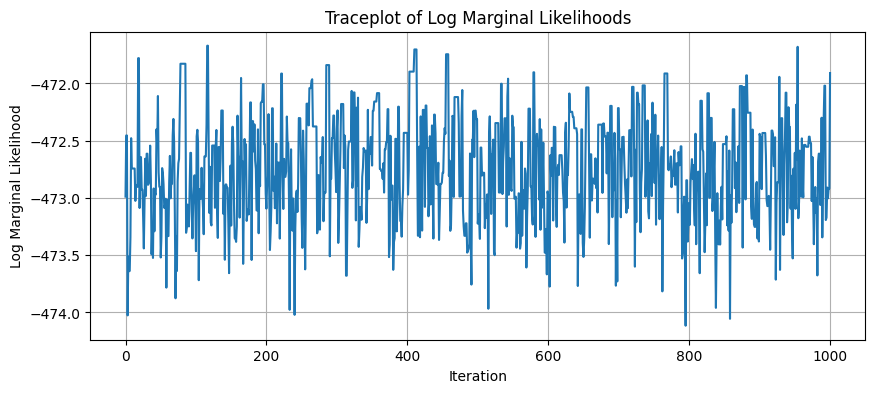

In [18]:
# Traceplot of log marginal likelihoods
plt.figure(figsize=(10, 4))
plt.plot(logmarliks)
plt.title('Traceplot of Log Marginal Likelihoods')
plt.xlabel('Iteration')
plt.ylabel('Log Marginal Likelihood')
plt.grid()
plt.show()

In [19]:
trajectories_h = np.array([state.h_t for state in samples])    # shape (T, n_traj)
trajectories_s = np.array([state.s_t for state in samples])    # shape (T, n_traj)
trajectories_s_prob = trajectories_s[:, :, 1]  # shape (T, n_traj)

h_mean_pimh = trajectories_h.mean(axis=1)  # mean across trajectories for each time step
s_prob_mean_pimh = trajectories_s_prob.mean(axis=1)  # mean across trajectories

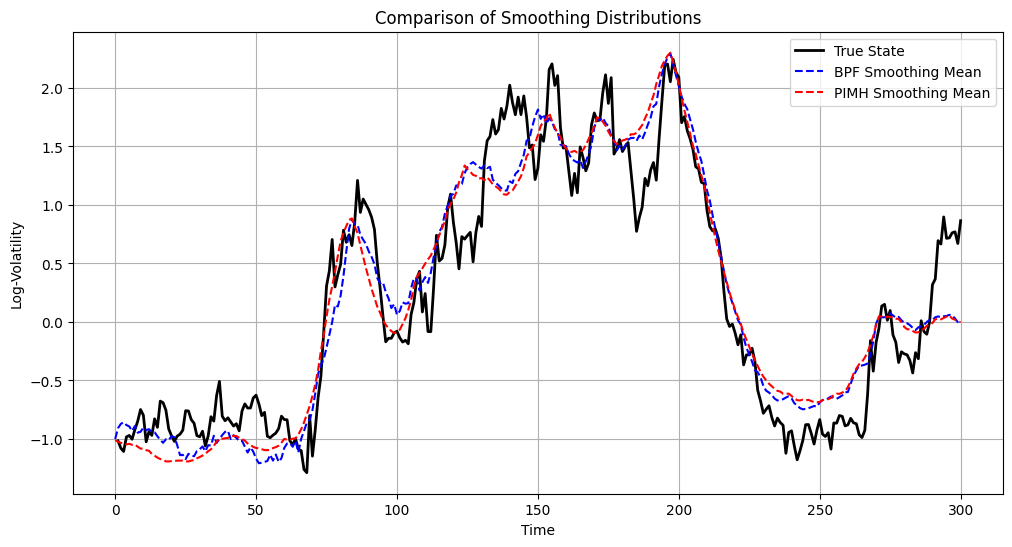

In [16]:
# Compare smoothing distribution from trajectories with smoothing distribution from PIMH samples relative to the true states
plt.figure(figsize=(12, 6))
plt.plot(np.arange(1, len(h_true) + 1), h_true, label='True State', color='black', linewidth=2)                 # Data starts at t=1
plt.plot(np.arange(0, len(h_mean)), h_mean, label='BPF Smoothing Mean', color='blue', linestyle='--')           # At t=0 we have the prior 
plt.plot(np.arange(0, len(h_mean_pimh)), h_mean_pimh, label='PIMH Smoothing Mean', color='red', linestyle='--') # Same here, t=0 is the prior
plt.title('Comparison of Smoothing Distributions')
plt.xlabel('Time')
plt.ylabel('Log-Volatility')
plt.legend()
plt.grid()
plt.show()

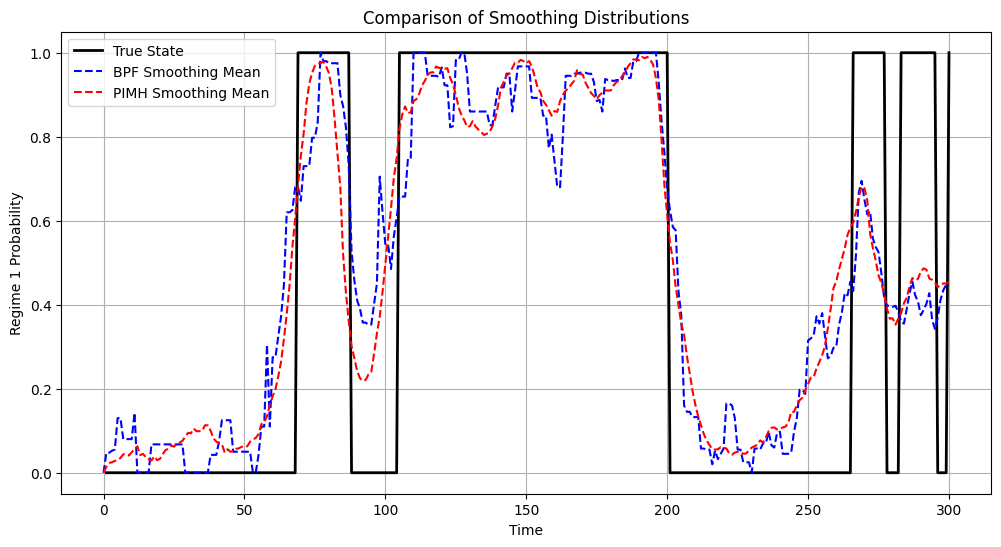

In [17]:
# Compare smoothing distribution from trajectories with smoothing distribution from PIMH samples relative to the true states
plt.figure(figsize=(12, 6))
plt.plot(np.arange(1, len(s_true[:,:,1]) + 1), s_true[:,:,1], label='True State', color='black', linewidth=2)                 # Data starts at t=1
plt.plot(np.arange(0, len(s_prob_mean)), s_prob_mean, label='BPF Smoothing Mean', color='blue', linestyle='--')           # At t=0 we have the prior 
plt.plot(np.arange(0, len(s_prob_mean_pimh)), s_prob_mean_pimh, label='PIMH Smoothing Mean', color='red', linestyle='--') # Same here, t=0 is the prior
plt.title('Comparison of Smoothing Distributions')
plt.xlabel('Time')
plt.ylabel('Regime 1 Probability')
plt.legend()
plt.grid()
plt.show()